<a class="anchor" id="0"></a>
# [OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction](https://www.kaggle.com/c/stanford-covid-vaccine)

## UPDATE:
In blending portion, earlier only three values were computed and rest two were filled with dummy values. However currently al 5 values need to be predicted. So change accordingly.

Current blending:

In [1]:
#blend_preds_df['reactivity'] = ensemble_final['reactivity'] 
#blend_preds_df['deg_Mg_pH10'] = ensemble_final['deg_Mg_pH10']
#blend_preds_df['deg_pH10'] = ensemble_final['deg_Mg_pH10']
#blend_preds_df['deg_Mg_50C'] = ensemble_final['deg_Mg_50C']
#blend_preds_df['deg_50C'] = ensemble_final['deg_Mg_50C']

To be corrected to:

In [2]:
#blend_preds_df['reactivity'] = ensemble_final['reactivity'] 
#blend_preds_df['deg_Mg_pH10'] = ensemble_final['deg_Mg_pH10']
#blend_preds_df['deg_pH10'] = ensemble_final['deg_pH10']
#blend_preds_df['deg_Mg_50C'] = ensemble_final['deg_Mg_50C']
#blend_preds_df['deg_50C'] = ensemble_final['deg_50C']

This notebook is based on a fork from [notebook](https://www.kaggle.com/vbmokin/gru-lstm-mix-custom-loss-tuning-by-3d-visual). I have replaced the existing models and added encoder portion of a transformer. Still needs tuning but it works. Hope you can make good use of it. Since my GPU quota for this week is over, has implemented for TPU as well. It should work fine with TPU, GPU or CPU.

## 1. Import libraries

In [3]:
import os 
import sys
import json
import math
import random
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, KFold,  StratifiedKFold

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L

import warnings
warnings.filterwarnings("ignore")

In [4]:
seed = 42

In [5]:
DEVICE = "TPU"
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    #if tf.config.list_physical_devices('gpu'):
    #    strategy = tf.distribute.MirroredStrategy()#if using multiple gpu
    #else:  # use default strategy
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))  
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
Number of devices: 8


In [6]:
dropout_model = 0.36
hidden_dim_first = 128
hidden_dim_second = 256
hidden_dim_third = 128

## 2. Read & Process Datasets

In [7]:
# Download datasets
train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)
sample_sub = pd.read_csv("/kaggle/input/stanford-covid-vaccine/sample_submission.csv")
train = train[train.signal_to_noise > 1]

In [8]:
# Target columns 
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [9]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

In [10]:
def preprocess_inputs(df, cols=['sequence','predicted_loop_type','structure']):
    base_features = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    return base_features

train_inputs_all = preprocess_inputs(train)
train_labels_all = np.array(train[target_cols].values.tolist()).transpose((0, 2, 1))

## 3. Transformer Encoder Model Implementation, Training & Prediction

In [11]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
  
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
     output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'depth': self.depth,
            'wq': self.wq,
            'qk': self.wk,
            'wv': self.wv,
            'dense': self.dense,
        })
        
        return config
def point_wise_feed_forward_network(d_model, dff):
      return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training):
        #mask made None
        attn_output, _ = self.mha(x, x, x, None)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_heads': self.num_heads,
            'rate': self.rate,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'mha': self.mha,
            'ffn': self.ffn,
        })
        return config

In [12]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

def build_model(model_type=1, seq_len=107, pred_len=68, embed_dim=32, 
                dropout=dropout_model, hidden_dim_first = hidden_dim_first, 
                hidden_dim_second = hidden_dim_second, hidden_dim_third = hidden_dim_third):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    categorical_feat_dim = 3
    categorical_fea = inputs[:, :, :categorical_feat_dim]
    
    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(categorical_fea)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    hidden = EncoderLayer(96, 8, 256)(reshaped)
    hidden = EncoderLayer(96, 8, 256)(hidden)
        
    truncated = hidden[:, :pred_len]

    out = tf.keras.layers.Dense(len(target_cols), activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    adam = tf.optimizers.Adam()
    model.compile(optimizer=adam, loss=MCRMSE, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [13]:
tf.keras.backend.clear_session()
from tqdm.keras import TqdmCallback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau()
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,min_delta=0.001, patience=10)

Model: model_1
Fold: 1



model_1 Min training loss=0.3978665769100189, min validation loss=0.3940463662147522
Intermediate ensemble result
   reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0    0.225823     0.299756  0.512269    0.281535  0.278770
1    0.225823     0.299756  0.512269    0.281535  0.278770
2    0.201164     0.179513  0.184750    0.216684  0.211989
3    0.201164     0.179513  0.184750    0.216684  0.211989
4    0.201164     0.179513  0.184750    0.216684  0.211989
Fold: 2



model_1 Min training loss=0.3985176682472229, min validation loss=0.3999730348587036
Intermediate ensemble result
   reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0    0.454544     0.578531  0.999254    0.554489  0.551995
1    0.454544     0.578531  0.999254    0.554489  0.551995
2    0.394860     0.333914  0.361379    0.422647  0.413521
3    0.394860     0.333914  0.361379    0.422647  0.413521
4    0.394860     0.333914  0.361379    0.422647  0.413521
Fold: 3



model_1 Min training loss=0.3986775875091553, min validation loss=0.3926484286785126
Intermediate ensemble result
   reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0    0.674672     0.858057  1.480339    0.827362  0.804743
1    0.674672     0.858057  1.480339    0.827362  0.804743
2    0.597281     0.489862  0.530085    0.623682  0.595890
3    0.597281     0.489862  0.530085    0.623682  0.595890
4    0.597281     0.489862  0.530085    0.623682  0.595890
Fold: 4



model_1 Min training loss=0.3986958861351013, min validation loss=0.393781840801239
Intermediate ensemble result
   reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0    0.876163     1.133782  1.962011    1.079423  1.052227
1    0.876163     1.133782  1.962011    1.079423  1.052227
2    0.786422     0.645812  0.693487    0.821028  0.778212
3    0.786422     0.645812  0.693487    0.821028  0.778212
4    0.786422     0.645812  0.693487    0.821028  0.778212
Fold: 5



model_1 Min training loss=0.39857393503189087, min validation loss=0.39172932505607605
Intermediate ensemble result
   reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0    1.138532     1.430071  2.484545    1.364288  1.320995
1    1.138532     1.430071  2.484545    1.364288  1.320995
2    0.989258     0.779715  0.853748    1.004550  0.952084
3    0.989258     0.779715  0.853748    1.004550  0.952084
4    0.989258     0.779715  0.853748    1.004550  0.952084
Mean Validation loss: 0.39443579912185667


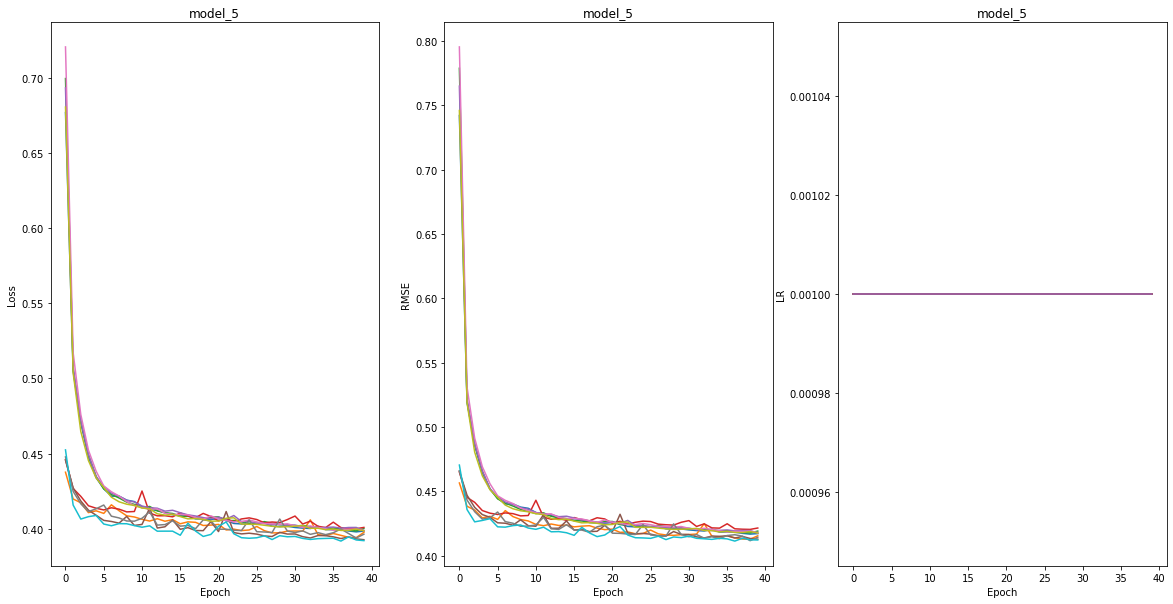

In [14]:
def train_and_predict(n_folds=5, model_name="model", model_type=0, epochs=100, debug=True,
                      dropout_model=dropout_model, hidden_dim_first = hidden_dim_first, 
                      hidden_dim_second = hidden_dim_second, hidden_dim_third = hidden_dim_third,
                      seed=seed):

    print("Model:", model_name)

    ensemble_preds = pd.DataFrame(index=sample_sub.index, columns=target_cols).fillna(0) # test dataframe with 0 values
    kf = KFold(n_folds, shuffle=True, random_state=seed)
    skf = StratifiedKFold(n_folds, shuffle=True, random_state=seed)
    val_losses = []
    historys = []

    for i, (train_index, val_index) in enumerate(skf.split(train_inputs_all, train['SN_filter'])):
        print("Fold:", str(i+1))
        with strategy.scope():
            model_train = build_model(model_type=model_type, 
                                      dropout=dropout_model, 
                                      hidden_dim_first = hidden_dim_first, 
                                      hidden_dim_second = hidden_dim_second, 
                                      hidden_dim_third = hidden_dim_third)
            model_short = build_model(model_type=model_type, seq_len=107, pred_len=107,
                                      dropout=dropout_model, 
                                      hidden_dim_first = hidden_dim_first, 
                                      hidden_dim_second = hidden_dim_second, 
                                      hidden_dim_third = hidden_dim_third)
            model_long = build_model(model_type=model_type, seq_len=130, pred_len=130,
                                     dropout=dropout_model, 
                                     hidden_dim_first = hidden_dim_first, 
                                     hidden_dim_second = hidden_dim_second, 
                                     hidden_dim_third = hidden_dim_third)

        train_inputs, train_labels = train_inputs_all[train_index], train_labels_all[train_index]
        val_inputs, val_labels = train_inputs_all[val_index], train_labels_all[val_index]

        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_name}_Fold_{str(i+1)}.h5')

        history = model_train.fit(
            train_inputs , train_labels, 
            validation_data=(val_inputs,val_labels),
            batch_size=64,
            epochs=epochs, 
            callbacks=[checkpoint,
                       lr_callback,
                       TqdmCallback(),
                       tf.keras.callbacks.TerminateOnNaN(),
                       es_callback],
            verbose= 0
        )

        print(f"{model_name} Min training loss={min(history.history['loss'])}, min validation loss={min(history.history['val_loss'])}")

        val_losses.append(min(history.history['val_loss']))
        historys.append(history)

        model_short.load_weights(f'{model_name}_Fold_{str(i+1)}.h5')
        model_long.load_weights(f'{model_name}_Fold_{str(i+1)}.h5')

        public_preds = model_short.predict(public_inputs)
        private_preds = model_long.predict(private_inputs)

        preds_model = []
        for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
            for i, uid in enumerate(df.id):
                single_pred = preds[i]

                single_df = pd.DataFrame(single_pred, columns=target_cols)
                single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

                preds_model.append(single_df)

        preds_model_df = pd.concat(preds_model)
        ensemble_preds[target_cols] += preds_model_df[target_cols].values / n_folds

        if debug:
            print("Intermediate ensemble result")
            print(ensemble_preds[target_cols].head())

    ensemble_preds["id_seqpos"] = preds_model_df["id_seqpos"].values
    ensemble_preds = pd.merge(sample_sub["id_seqpos"], ensemble_preds, on="id_seqpos", how="left")

    print("Mean Validation loss:", str(np.mean(val_losses)))

    if debug:
        fig, ax = plt.subplots(1, 3, figsize = (20, 10))
        for i, history in enumerate(historys):
            ax[0].plot(history.history['loss'])
            ax[0].plot(history.history['val_loss'])
            ax[0].set_title('model_'+str(i+1))
            ax[0].set_ylabel('Loss')
            ax[0].set_xlabel('Epoch')
            
            ax[1].plot(history.history['root_mean_squared_error'])
            ax[1].plot(history.history['val_root_mean_squared_error'])
            ax[1].set_title('model_'+str(i+1))
            ax[1].set_ylabel('RMSE')
            ax[1].set_xlabel('Epoch')
            
            ax[2].plot(history.history['lr'])
            ax[2].set_title('model_'+str(i+1))
            ax[2].set_ylabel('LR')
            ax[2].set_xlabel('Epoch')
        plt.show()

    return ensemble_preds


public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()
public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)

ensembles = []

for i in range(1):
    model_name = "model_"+str(i+1)

    ensemble = train_and_predict(n_folds=5, model_name=model_name, model_type=i, epochs=40,
                                 dropout_model=dropout_model, hidden_dim_first = hidden_dim_first, 
                                 hidden_dim_second = hidden_dim_second, hidden_dim_third = hidden_dim_third,
                                 seed=seed)
    ensembles.append(ensemble)

## 4. Ensembling the solutions and submission


In [15]:
# Ensembling the solutions
ensemble_final = ensembles[0].copy()
ensemble_final[target_cols] = 0

for ensemble in ensembles:
    ensemble_final[target_cols] += ensemble[target_cols].values / len(ensembles)

ensemble_final.head().T

,0,1,2,3,4
id_seqpos,id_00073f8be_0,id_00073f8be_1,id_00073f8be_2,id_00073f8be_3,id_00073f8be_4
reactivity,1.13853,1.13853,0.989258,0.989258,0.989258
deg_Mg_pH10,1.43007,1.43007,0.779715,0.779715,0.779715
deg_pH10,2.48454,2.48454,0.853748,0.853748,0.853748
deg_Mg_50C,1.36429,1.36429,1.00455,1.00455,1.00455
deg_50C,1.321,1.321,0.952084,0.952084,0.952084


In [16]:
blend_preds_df = pd.DataFrame()
blend_preds_df['id_seqpos'] = ensemble_final['id_seqpos']
blend_preds_df['reactivity'] = ensemble_final['reactivity'] 
blend_preds_df['deg_Mg_pH10'] = ensemble_final['deg_Mg_pH10']
blend_preds_df['deg_pH10'] = ensemble_final['deg_pH10']
blend_preds_df['deg_Mg_50C'] = ensemble_final['deg_Mg_50C']
blend_preds_df['deg_50C'] = ensemble_final['deg_50C']
blend_preds_df.head().T

,0,1,2,3,4
id_seqpos,id_00073f8be_0,id_00073f8be_1,id_00073f8be_2,id_00073f8be_3,id_00073f8be_4
reactivity,1.13853,1.13853,0.989258,0.989258,0.989258
deg_Mg_pH10,1.43007,1.43007,0.779715,0.779715,0.779715
deg_pH10,2.48454,2.48454,0.853748,0.853748,0.853748
deg_Mg_50C,1.36429,1.36429,1.00455,1.00455,1.00455
deg_50C,1.321,1.321,0.952084,0.952084,0.952084


In [17]:
# Submission
blend_preds_df.to_csv('ensemble_final.csv', index=False)

#EOF